## Import required packages

In [1]:
#Import required packages
import numpy as np
import pandas as pd
import brightway2 as bw
import sys
import matplotlib.pyplot as plt
import os

In [2]:
#Local modules
#path to ODYM:
sys.path.insert(0, os.path.join(r"C:\Users\Joris\OneDrive - Newcastle University\Python\ODYM")) 
import ODYM_Classes as msc
import ODYM_Functions as msf
import dynamic_stock_model as dsm



#Import the battery design module from a local path
local_path =r"C:\Users\Joris\OneDrive - Newcastle University\Python\Projects\Batt_Sust_Model-1\batt_sust_model" #ADD PATH
sys.path.insert(1, local_path)
from battery_design import battery_design as bd
import battery_cost as bat_cost
import battery_emissions as bat_lca

#Local path to BatPaC version 5
path_batpac = r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\battery_sustainability_model\Case study\BatPaC 5.0 - 8March2022.xlsm"#ADD PATH


# log_verbosity = eval("log.INFO")
# log_filename  = 'log_file.md'
# [Mylog, console_log, file_log] = msf.function_logger(log_filename, os.getcwd(),
#                                                      log_verbosity, log_verbosity)



# Battery manufacturing costs (example 1)

The price of the battery are determined ..

Battery manufacturing costs are calculated through both methods. 

Price vector methods for upstream materials.... 


Value added per process ($b$) is determined for each battery system.. 

## Establish foreground system
First, the material content of a single battery is obtained. The design of the Volkswagen MEB platform, 77 kWh version as reported by
[PushEVS.com](https://pushevs.com/2020/05/13/volkswagen-meb-details/) is used as an example (NMC622 is used instead of NMC712, as the latter is not in the public version of BatPaC V5). All other parameters are BatPaC default parameters.

* usable battery energy: 94%
* Total pack energy: 82 kWh
* Electrode pair: NMC622-G
* Silicon additive anode: 0%
* Cells per module: 24
* Modules per pack: 12
* Modules in parallel: 2 
* Maximum charging time: 33 minutes (ev-database.org)
* Maximum charge power: 135 kW (ev-database.org)
<br>

<!-- <a href=https://www.volkswagen-newsroom.com/en/press-releases/long-range-and-rapid-charging-the-battery-system-is-at-the-heart-of-the-volkswagen-id3-id4-and-id4-gtx-7130>
<center><img src='../docs/ID pack.jpg' width=600/> <br></center>
<figcaption align = "center"><b>Structure of the Volkswagen MEB platform (VW, 2021) </b></figcaption>

In [3]:
#Establish battery system class of specific design:
battery = bd.Battery_system (    
                             vehicle_type='EV', 
                             electrode_pair='50%/50% NMC532/LMO - G', 
                             cells_per_module=24, 
                             modules_per_row=6,
                             rows_of_modules=2, 
                             cells_in_parallel=1,
                             silicon_anode= 0.00, 
                             calculate_fast_charge = 'Yes',
                             max_charging_time = 34,  #EV-database https://ev-database.org/car/1273/Volkswagen-ID4-1st
                             max_charge_power = 126,  #EV-database https://ev-database.org/car/1273/Volkswagen-ID4-1st
                             available_energy=94,
                             A_coefficient=135.9999272, #based on EPA data
                             B_coefficient= 3.732390689,#based on EPA data
                             C_coefficient=0.406771986,#based on EPA data
                             vehicle_range_miles =410*0.6214, #EV-database using the 'EVDB Real Range' (converted to miles) https://ev-database.org/car/1273/Volkswagen-ID4-1st
                             motor_power = 150 #Based on adac.de VW ID.4 Pro Performance https://www.adac.de/rund-ums-fahrzeug/autokatalog/marken-modelle/vw/id4/1generation/318521/#technische-daten                 
                             )
#Establish parameter dictionary
parameter_dict = battery.parameter_dictionary()

In [4]:
# #Solve battery design in BatPaC returning nested dictionary with material contents and parameter values
# #Make sure BatPaC is not open or running in the background
bp_output = bd.solve_batpac_battery_system (batpac_path = path_batpac, parameter_dict=parameter_dict, visible=True)

### Quantify material flows in physical

In [5]:
#Brightway2 general setup:
bw.projects.set_current('parameterised_battery_lca')
bw.bw2setup()
#Import ecoinvent 3.7.1:
if 'eidb 3.7' in bw.databases:
    pass
else:
    pathi37 = 'path to ecoinvent'
    eidb37 = bw.SingleOutputEcospold2Importer(pathi37, 'eidb 3.7')
    eidb37.apply_strategies()
    eidb37.statistics()


Biosphere database already present!!! No setup is needed


In [6]:
bat_lca.get_project_parameters_dict(bp_output)

{'anode_active_material': 21.97134626759194,
 'anode_active_material_natural_graphite': 0.0,
 'anode_active_material_sinw': 0.0,
 'anode_active_material_sio': 0.0,
 'anode_active_material_synthetic_graphite': 21.97134626759194,
 'anode_binder_additive_sbr': 0.4625546582650936,
 'anode_binder_cmc': 0.6938319873976403,
 'anode_carbon_black': 0.0,
 'anode_coating_drying_mixing_ratio': 0.24,
 'anode_current_collector': 16.0356768397375,
 'anode_current_collector_cu_6um': 0.0,
 'anode_current_collector_cu_7um': 0.0,
 'anode_current_collector_cu_8um': 0.0,
 'anode_current_collector_cu_9um': 0.0,
 'anode_current_collector_cu_10um': 16.0356768397375,
 'anode_current_collector_cu_11um': 0.0,
 'anode_current_collector_cu_12um': 0.0,
 'anode_current_collector_cu_13um': 0.0,
 'anode_current_collector_cu_14um': 0.0,
 'anode_mixing_ratio_electricity': 0.35,
 'anode_slurry': 57.52255186709739,
 'anode_dry_material': 26.146614485044267,
 'battery_capacity': 23.50000000000003,
 'battery_jacket': 35.383

In [7]:
result_dict = bat_lca.output_as_bw_param(bp_output)

# Append additional project parameters and recalculate project parameters (e.g. total anode active material based on process yield)
#Convert BatPaC output to Brightway parameter names and update
result_dict = {**bat_lca.get_project_parameters_dict(bp_output), **result_dict}
#Append battery design parameters:
result_dict.update(bp_output['general_battery_parameters'])

In [8]:
# #Reset 
bat_lca.update_param_battery_bw(result_dict)


# # Cut off the exchanges if activity if present in the 'cut off database'. E.g. 6um copper foil production is present in the 'cut of database' and will be cut in the anode coating process. All cut-off exchanges are set to zero
# a = bat_lca.modules_with_cuts('cut_off')

# # Divide all battery production activities by total battery system weight:

# bat_product_act = [act['name'] for act in bw.Database('battery_production')]
# for act in bat_product_act:
#     pack_weight = result_dict['battery_pack']
#     a[act]['amount'] = a[act]['amount']
#     for exc in a[act]['cuts'].keys():
#         a[act]['cuts'][exc][1] = a[act]['cuts'][exc][1]
# #Cut modules:
# bat_lca.cut_modules_to_zero(a)

# # Establish product-module dataframe of base system
# A=bat_lca.modular_technology_matrix(a)

In [9]:
# A_inv = pd.DataFrame(np.linalg.pinv(A.values), A.columns, A.index)


In [10]:
# actor cost UK, from Duffner et al (land ($/m2), labour ($/hr), capital ($)):
factor_cost          = np.array([2427, 24.75, 1])

In [11]:
# factor_cost = ParameterDict['3_PR_factor_price'].Values[:,4]
result_dict['battery_manufacturing_capacity'] = 500000

F = bat_cost.factors_battery_production(result_dict, return_aggregated=True)

Overview of process factor requirements:

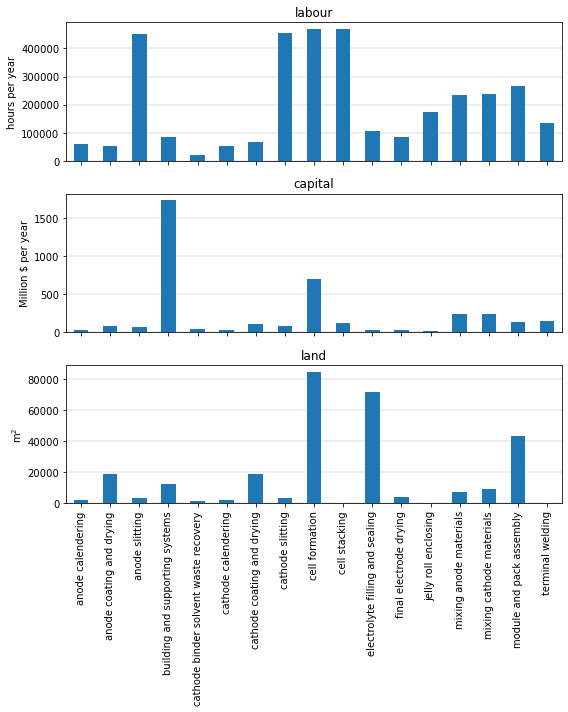

In [12]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(8,10))

for i, row in enumerate(F.index):
    F.loc[row].plot.bar(ax=ax[i], zorder=2)
    ax[i].set_title(row)
    ax[i].grid(lw=0.4, axis='y', zorder=0)
    
ax[0].set_ylabel('hours per year')
ax[1].set_ylabel('Million $ per year')
ax[2].set_ylabel(r'm$^2$')

fig.tight_layout()



And the fully monetary $\bf{F}$ matrix ($\bf{F}_m$) can be obtained by multiplying F with the factor cost. 

The operating expenses (e.g. R&D investments and depreciation rates) are allocated to the factor cost based on the multipliers for overhead to basic costs as used in BatPaC.

Using the same factor used as in BatPaC, the total labour, capital and land cost are identical to the values in BatPaC, sheet 'Cost Breakdown'


In [127]:
#Default BatPaC values (labour ($/hr), capital ($) land ($/m2)):
factor_cost          = pd.Series([25, 1000000, 3000], index=['labour', 'capital', 'land'])
factor_cost_multiplier = pd.Series(bat_cost.factor_overhead_multiplier())
F_m = ((factor_cost*factor_cost_multiplier)*F.T).T
F_m.sum(axis=1)/500000

labour      318.952169
capital    1943.314073
land        263.134715
dtype: float64

In [ ]:
factor_cost = []

for 

In [ ]:


factor_cost_overhead = list(bat_cost.factor_overhead_multiplier (100000).values())
B = (F.T*(factor_cost*factor_cost_overhead))
B.sum().astype(int)/100000
b = B.T.sum(axis=0)/100000
C = bat_cost.material_cost_matrix (A, df_pr_material_mass, df_pr_material_unit, material_category,baseline_parameters_path, result_dict)
C_all = internal_material_cost(internal_materials, materials, A, C, b)

#Inverse the A' matrix:
A_inv = pd.DataFrame(np.linalg.pinv(A.values), A.columns, A.index)

#Establish final product demand vector for 1 battery based on pack weight
y = pd.Series(data = 0, index=A.index)
y.loc['battery pack'] = pack_weight 

#Calculate scaling vector:
s = A_inv.dot(y)


C_all.dot(s).sum()/82

NameError: name 'A' is not defined

In [ ]:
def labour_overhead_multiplier(
    variable_overhead_labor=0.4,
    GSA=0.25,
    pack_profit=0.05,
    investment_cost=0.10,
    working_capital=0.15,
    battery_warranty_costs=0.056,
):
    """The factor cost overhead multiplier for direct labour. Function and parameters are based on BatPaC V5."""
    a = (
        1
        + variable_overhead_labor
        + GSA * (1 + variable_overhead_labor)
        + pack_profit
        * (
            investment_cost * (1 + variable_overhead_labor)
            + working_capital * (1 + variable_overhead_labor)
        )
    )
    return a * (1 + battery_warranty_costs)


def capital_overhead_multiplier(
    variable_overhead_deprecation=0.2,  # f94
    GSA_deprecation=0.25,  # 99
    GSA_labour=0.25,  # 98
    r_and_d=0.4,  # 100
    deprecation_capital_equipment=0.1,  # 103
    launch_cost_labor=0.10,  # 86
    working_capital=0.15,  # 87
    pack_profit=0.05,  # f109
    battery_warranty_costs=0.056,  # f110
):
    """The factor cost overhead multiplier for capital equipment. Function and parameters are based on BatPaC V5."""
    a = (
        variable_overhead_deprecation
        + GSA_deprecation
        + GSA_labour * variable_overhead_deprecation
        + r_and_d
        + 1
    )
    b = (
        1
        + variable_overhead_deprecation
        * (launch_cost_labor + working_capital)
        * deprecation_capital_equipment
    )
    return (a * deprecation_capital_equipment + b * pack_profit) * (
        1 + battery_warranty_costs
    )

def land_overhead_multiplier(
    variable_overhead_deprecation=0.2,  # f94
    GSA_deprecation=0.25,  # 99
    GSA_labour=0.25,  # 98
    r_and_d=0.4,  # 100
    deprecation_building_investment=0.05,  # 104
    launch_cost_labor=0.10,  # 86
    working_capital=0.15,  # 87
    pack_profit=0.05,  # f109
    battery_warranty_costs=0.056,  # f110
):
    """The factor cost overhead multiplier for capital equipment. Function and parameters are based on BatPaC V5."""
    a = (
        variable_overhead_deprecation
        + GSA_deprecation
        + GSA_labour * variable_overhead_deprecation
        + r_and_d
        + 1
    )
    b = (
        1
        + variable_overhead_deprecation
        * (launch_cost_labor + working_capital)
        * deprecation_building_investment
    )
    return (a * deprecation_building_investment + b * pack_profit) * (
        1 + battery_warranty_costs
    )

def factor_overhead_multiplier(
):
    """Returns the factor cost overhead multiplier. Capital is converted from
    millions"""
    land_overhead = land_overhead_multiplier()
    labour_overhead = labour_overhead_multiplier()
    capital_overhead = capital_overhead_multiplier()
    baseline_production_capacity = 500000
    multiplier_dict = {}
    multiplier_dict["land"] = land_overhead * baseline_production_capacity / 1000000
    multiplier_dict["labour"] = labour_overhead
    multiplier_dict["capital"] = capital_overhead * baseline_production_capacity
    return multiplier_dict


In [ ]:
C_all.loc[:,IndexTable.loc['Production_processes','Classification'].Items].to_excel(r'C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\notebooks\Data\delete.xlsx')

# Calculate the value added per process ($\pi$) 

The battery value added refers to the cost of the primary production factors, similar to the system cost of MFCA. The value added ($v$) per process is based on the rectangular choice-of-technology model (RCOT) by Duchin and Levine (2011) and the LCA extension by Katelhon et al 2016. Here value added per process is calculated with 

$$v = F'\pi$$

where $F'$ is the transpose ($'$) of the physical factor requirement matrix where rows refer to the factors and columns to the process, and $\pi$ is the price per unit factor.  <br>


## Factor requirement matrix ($F$)

Factor requirement ($F$) for all battery production process are based on the calculations of BatPaC as described in the BatPaC manual. Here factor requirements are adjusted to account for varying production volumes with the following equation:
$$F= F_b \left(\frac{P}{P_b}\right)^p$$

where $F_b$ refers to the baseline factor requirement matrix, $P$ to the modelled annual production process rate, $P_b$ to the base line process rate and $p$ is the scale factor. $F_b$, $P_b$ and $p$ are obtained from BatPaC.


In [ ]:
baseline_parameters_path = r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Model\data\manufacturing_cost_parameters.xlsx"
#
result_dict['design_parameters']['battery_manufacturing_capacity'] = 100000
F = bat_cost.factors_battery_production(result_dict, baseline_parameters_path, return_aggregated=True)
F

,anode calendering,anode coating and drying,anode slitting,cathode binder solvent waste recovery,cathode calendering,cathode coating and drying,cathode slitting,cell formation,cell stacking,electrolyte filling and sealing,final electrode drying,jelly roll enclosing,mixing anode materials,mixing cathode materials,module and pack assembly,receiving and shipping,terminal welding
land,669.172258,1769.858221,334.586129,403.024420,669.172258,1769.858221,334.586129,5145.997512,2082.655802,2008.081114,803.006709,669.360371,893.767445,1023.180226,3012.121671,9415.015086,1388.437201
labour,36716.878928,45896.098660,27537.659196,12472.018040,36716.878928,45896.098660,27537.659196,115068.916127,81801.142120,70984.843305,36716.878928,31548.819247,26478.446076,29636.858492,173518.505856,270534.714287,81801.142120
capital,3.512389,19.220953,2.809911,12.090733,3.512389,19.928519,2.809911,100.167183,10.181873,13.633524,5.619822,4.544508,9.309198,10.900033,28.899763,48.651466,13.884372


## Factor cost per process 
Factor cost per unit process ($b$) is calculated based on the element-wise multiplication (Hadamard product, $\circ$) of the factor requirement matrix ($F'$) and the factor price ($\pi$):
$$b=F'\circ \pi$$

In BatPaC, additional variable overhead costs (indirect cost related to materials, labour, utilities and plant maintance) and fixed expenses are included as reported in BatPaC. 
Overhead costs are here all attributed to single processes, such that $pi$ is calculated with:
$$\pi = \pi_{cost} \pi_{overhead}$$

where $\pi_{overhead}$ is the overhead multiplier. The overhead multiplier for capital ($cap$) and land ($land$) are  calculatd with:
$$\pi_{overhead} = \frac{default_{overhead} default_{capacity}}{capacity}$$

In [ ]:
# BatPaC default factor cost (land ($/m2), labour ($/hr), capital ($)):
factor_cost          = np.array([3000, 25, 1])

# factor_cost = ParameterDict['3_PR_factor_price'].Values[:,4]
result_dict['design_parameters']['battery_manufacturing_capacity'] = 100000
F = bat_cost.factors_battery_production(result_dict, baseline_parameters_path, return_aggregated=True)
F

factor_cost_overhead = list(bat_cost.factor_overhead_multiplier (100000).values())
B = (F.T*(factor_cost*factor_cost_overhead))
B.sum().astype(int)/100000


land        148.92167
labour      537.02170
capital    1200.43016
dtype: float64

## Value added per pack and per process ($v$)

In [ ]:
b = B.T.sum(axis=0)/100000
b

anode calendering                         33.824957
anode coating and drying                 104.061291
anode slitting                            25.280359
cathode binder solvent waste recovery     54.541176
cathode calendering                       33.824957
cathode coating and drying               106.804101
cathode slitting                          25.280359
cell formation                           465.640825
cell stacking                             87.214480
electrolyte filling and sealing           95.204447
final electrode drying                    42.609515
jelly roll enclosing                      35.415182
mixing anode materials                    52.550777
mixing cathode materials                  60.786259
module and pack assembly                 206.843344
receiving and shipping                   358.116336
terminal welding                          98.375178
dtype: float64

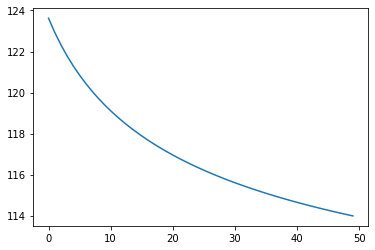

In [ ]:
pack_cost_kwh = [x/60 for x in pack_cost]

plt.plot(pack_cost_kwh)

### Impact of production capacity:

Text(0.5, 1.0, 'Factor cost per battery pack by battery production capacity')

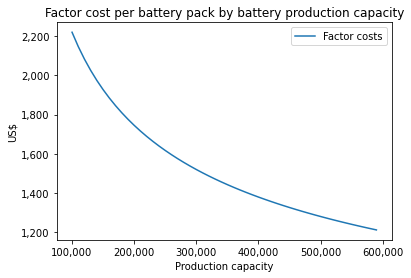

In [ ]:
production = list(range(100000, 600000, 10000))
land = []
labour = []
capital = []

for x in production:
    result_dict['design_parameters']['battery_manufacturing_capacity'] = x
    F = bat_cost.factors_battery_production(result_dict, baseline_parameters_path)
    factor_cost_overhead = list(bat_cost.factor_overhead_multiplier(x).values())
    
    a = (F.T*(factor_cost*factor_cost_overhead))
    f = a.sum()/x
    land.append(f[0])
    labour.append(f[1])
    capital.append(f[2])
    
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
a = [land, labour, capital]
factor_cost_all = sum(map(np.array, a))

fig, ax = plt.subplots()
ax.plot(production, factor_cost_all,label='Factor costs')
plt.ylabel('US$')

ax.legend()
plt.xlabel('Production capacity')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
plt.title('Factor cost per battery pack by battery production capacity')

### Factor cost for different countries:

Text(0, 0.5, 'US$')

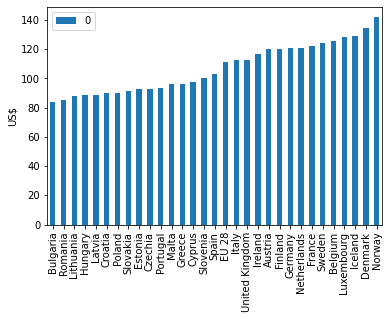

In [ ]:
ParameterDict['3_PR_factor_price'].Values

production = list(range(100000, 600000, 10000))
cost_total = []

for x in range(ParameterDict['3_PR_factor_price'].Values.shape[1]):
    factor_cost = (ParameterDict['3_PR_factor_price'].Values[:,x])    
    factor_cost_overhead = list(bat_cost.factor_overhead_multiplier(100000).values())
    a = (F.T*(factor_cost*factor_cost_overhead))
    f = a.sum()/100000
    cost_total.append(f.sum())

df = pd.DataFrame(cost_total, IndexTable.loc['Regions', 'Classification'].Items,)    
    
(df.sort_values(by=0)/60).plot.bar()
plt.ylabel('US$')